#### Testeo Modelos 
En este sección vamos a realizar testeos de los diferentes modelos que se guardaron.

Recorda que hicimos entrenamiento por separado. Por un lado tenemos un entrenamiento basado solo en 
latitudes y longitudes, es decir un modelo de predicción de latitudes y longitudes, y por otro lado se tiene un modelo dedicado solo a la prediccion de las alturas. 

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.models import load_model
import pickle
from Utils import plotter as utlnn
from Utils import geo_conversions as gc
%matplotlib widget

In [ ]:
#Carga conjunto de Test.

x_test = pd.read_excel("./Train_Test/Dataset_Separado/x_test_new.xlsx")
y_test = pd.read_excel("./Train_Test/Dataset_Separado/y_test_new.xlsx")


In [ ]:
# Quita de columnas no usadas en Train 
x_test = x_test.drop(columns=['latitude_pos_tx', 'longitude_pos_tx', 'elevation_pos_tx', 'year'])

In [ ]:
#Carga de Modelos Entrenados.
#modelo separado
# autoencoder_x =  load_model('./modelos_entrenamiento/mod_x_R0/modelo1_x_con_scaler/modelo1_x.keras')
# with open('./modelos_entrenamiento/mod_x_R0/modelo1_x_con_scaler/scaler_x1.pkl', 'rb') as f:
#   scaler_x = pickle.load(f)

# autoencoder_y = load_model('./modelos_entrenamiento/mod_y_R0/modelo1_y_con_scaler/modelo1_y.keras')
# with open('./modelos_entrenamiento/mod_y_R0/modelo1_y_con_scaler/scaler_y1.pkl', 'rb') as f:
#   scaler_y = pickle.load(f)
  
autoencoder_z = load_model('./modelos_entrenamiento/mod_z_R0/modelo1_con_scaler/modelo1.keras')
with open('./modelos_entrenamiento/mod_z_R0/modelo1_con_scaler/scaler_z1.pkl','rb') as f:
  scaler_z = pickle.load(f)

model_xy = load_model('./modelos_entrenamiento/mod_x_y_R0/modelo1_x_y_con_scaler/mod_x_y_R0.keras')
with open('./modelos_entrenamiento/mod_x_y_R0/modelo1_x_y_con_scaler/scaler_x.pkl', 'rb') as f:
	scaler_x = pickle.load(f)
with open('./modelos_entrenamiento/mod_x_y_R0/modelo1_x_y_con_scaler/scaler_y.pkl', 'rb') as f:
	scaler_y = pickle.load(f)



In [ ]:
# Valores verdaderos
idx = 0
R0 = 6.371E6


y_true_x = (y_test.iloc[idx].to_numpy())[0:100]
y_true_y = (y_test.iloc[idx].to_numpy())[100:200]
y_true_z = (y_test.iloc[idx].to_numpy())[200:300]

# Predicciones
#Prediccion x y por separado
# y_pred_scaled_x = autoencoder_x.predict(np.expand_dims(x_test.iloc[idx], axis = 0))
# y_pred_scaled_y = autoencoder_y.predict(np.expand_dims(x_test.iloc[idx], axis = 0))
# Predicción x_y juntos
y_pred_scaled_x, y_pred_scaled_y = model_xy.predict(np.expand_dims(x_test.iloc[idx],axis = 0))
#Predicción x y único modelo
y_pred_scaled_z = autoencoder_z.predict(np.expand_dims(x_test.iloc[idx], axis = 0))

y_pred_x = scaler_x.inverse_transform(y_pred_scaled_x).flatten() * R0
y_pred_y = scaler_y.inverse_transform(y_pred_scaled_y).flatten() * R0
y_pred_z = scaler_z.inverse_transform(y_pred_scaled_z).flatten() * R0


In [ ]:
# Graficar resultados
plt.figure(figsize = (12,6))
plt.plot(y_true_x, label = 'True x', color = 'blue')
plt.plot(y_pred_x, label = 'Pred x', color = 'red')
plt.title('Comparación de valores verdaderos y predicciones para X')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize = (12,6))
plt.plot(y_true_y, label = 'True y', color = 'blue')
plt.plot(y_pred_y, label = 'Pred y', color = 'red')
plt.title('Comparación de valores verdaderos y predicciones para Y')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize = (12,6))
plt.plot(y_true_z, label = 'True z', color = 'blue')
plt.plot(y_pred_z, label = 'Pred z', color = 'red')
plt.title('Comparación de valores verdaderos y predicciones para Z')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
#Transformación de coordenadas cartesianas a esféricas y luego a geográficas tanto en test como en predicción.

phi_true, theta_true, rho_true = gc.transform_cartesian_to_spherical(y_true_x, y_true_y, y_true_z)
lat_true, lon_true, alt_true = gc.transform_spherical_to_geographic(phi_true, theta_true, rho_true)

phi_pred, theta_pred, rho_pred = gc.transform_cartesian_to_spherical(y_pred_x, y_pred_y, y_pred_z)
lat_pred, lon_pred, alt_pred = gc.transform_spherical_to_geographic(phi_pred, theta_pred, rho_pred)

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(lat_true, label = 'True Lat', color = 'blue')
plt.plot(lat_pred, label = 'Pred Lat', color = 'red')
plt.ylim(lat_true.min() - 0.5, lat_true.max() + 0.5)
plt.title('Comparación Latitud Test vs Predicción')
plt.ylabel('Latitud (grados)')
plt.xlabel('Muestras')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize= (12,6))
plt.plot(lon_true, label = 'True Lon', color = 'blue')
plt.plot(lon_pred, label = 'Pred Lon', color = 'red')
plt.ylim(lon_true.min() - 0.5, lon_true.max() + 0.5)
plt.title('Comparación Longitud Test vs Predicción')
plt.ylabel('Longitud (grados)')
plt.xlabel('Muestras')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize = (12,6))
plt.plot(alt_true-R0, label = 'True Alt', color = 'blue')
plt.plot(alt_pred-R0, label = 'Pred Alt', color = 'red')
plt.title('Comparación Altitud Test vs Predicción')
plt.ylabel('Altitud (m)')
plt.xlabel('Muestras')
plt.grid()
plt.legend()
plt.show()


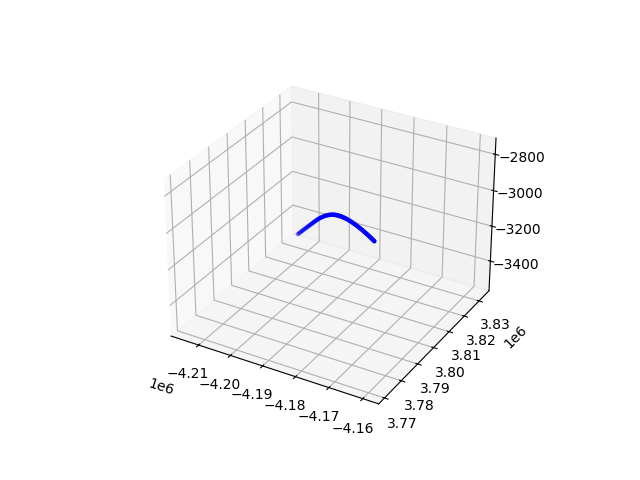

In [101]:

X = alt_true *np.cos(phi_true)*np.sin(theta_true)
Y = alt_true *np.sin(phi_true)*np.sin(theta_true)
Z = alt_true *np.cos(theta_true)

fig = plt.figure()
ax 	= fig.add_subplot(projection='3d')

ax.scatter(X, Y,(Z-R0)/1E3, color = 'blue', marker = '.')
plt.show()

# Nota: A que se puede deber que 

In [ ]:
# NOTAS:-----------------------
#De aqui en adelante aún no se trato.

## Errores 
1. Error de manera individual:
  * Puedo calcular $d_{2D}$ usando **geopy.distance.geodesic**.
  * Luego calcular la diferencia de alturas $\Delta z$
  * Finalmente usar un $d_{3D} = \sqrt{(d_{2D})^2 + (\Delta z)^2}$ y así obtendría mi distancia en 3D.
2. ECM
  * Para obtener el Error Cuadrático Medio puedo, sumar los valores y dividir por la cantidad de puntos (100 puntos)
3. RECM(RMSE)
  * Por último se podría tomar la raiz del ECM para expresar el error promedio en metros.

In [ ]:
# Distance_havers = utlnn.haversine_distance(y_true_latitudes,y_true_longitudes,y_pred_latitudes,y_pred_longitudes)
# Distance_havers = utlnn.haversine_distance(y_true_latitudes,y_true_longitudes,lat_pred)

In [ ]:
# plot = False
# # Calculamos el error 
# error = np.sum(Distance_havers**2)/len(Distance_havers)
# print("Raiz del ECM:",np.sqrt(error))

# if plot == True:
#   plt.figure(figsize=(15,6))
#   plt.bar(range(len(Distance_havers)), Distance_havers, color='skyblue')
#   plt.xlabel('Índice')
#   plt.ylabel('Error (distancia)')
#   plt.title('Errores como distancias')
#   plt.show()

In [ ]:
# # distance = utlnn.distances_by_geodesic(y_true_latitudes,y_true_longitudes,y_pred_latitudes,y_pred_longitudes) #Km
# distance = utlnn.distances_by_geodesic(y_true_latitudes,y_true_longitudes,lat_pred,lon_pred) #Km
# print(f"distancia 2D: {distance}")
# sq_distance = distance**2
# error_2d = np.sum(sq_distance)/len(sq_distance) #ECM
# sqrt_error_2d = np.sqrt(error_2d)
# print("Raiz del error ECM:",error_2d,sqrt_error_2d)


In [ ]:
# plot1 = False
# if plot1 == True:
#   plt.figure(figsize=(15,6))
#   plt.bar(range(len(distance)), distance, color='skyblue')
#   plt.xlabel('Índice')
#   plt.ylabel('Error (distancia)')
#   plt.title('Errores como distancias 2D Km')
#   plt.show()

In [ ]:
# distance_3d = utlnn.distances_3D(distance,y_true_heights,y_pred_heights)   
# plot = False 
# if plot == True:
#   plt.figure(figsize=(15,6))
#   plt.bar(range(len(distance_3d)), distance_3d, color='skyblue')
#   plt.xlabel('Índice')
#   plt.title('Errores como distancias 2D Km')
#   plt.show()
# print(distance_3d)